In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import patches
import bug_utils as bug
import importlib
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import train_test_split
importlib.reload(bug)


<module 'bug_utils' from '/Users/oren2/Documents/udacity/hexbug/bug_utils.py'>

In [2]:
bug.rmse

<function bug_utils.rmse>

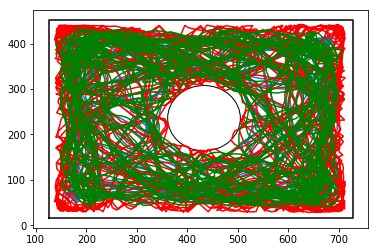

In [3]:
traj_fig = bug.show_video_trajectory("330 minute 1_features.csv")

In [4]:
train_df, label_df = bug.split_all_videos_random(10,19,1)

train_df (10, 38) label_df (10, 2)


In [5]:
train_df.head()

0               1               2               3              4   \
      C_x     C_y     C_x     C_y     C_x     C_y     C_x    C_y     C_x   
0  176.25   62.00  176.50   65.50  174.00   70.75  172.50   77.0  172.50   
1  676.00  107.75  670.50   93.50  665.75   81.25  660.00   71.0  652.75   
2  572.50  400.50  580.00  394.50  586.00  387.50  591.75  380.5  598.00   
3  407.50  101.50  396.75  110.75  388.00  121.50  379.50  131.0  373.00   
4  177.75  368.25  177.50  370.50  177.50  370.50  178.00  386.0  178.00   

            ...        14              15              16              17  \
      C_y   ...       C_x     C_y     C_x     C_y     C_x     C_y     C_x   
0   77.00   ...    203.00  178.00  208.25  186.75  214.25  195.75  221.00   
1   62.75   ...    562.75  124.25  553.50  132.50  546.00  141.00  539.00   
2  373.00   ...    642.50  287.75  646.50  280.00  647.75  271.75  652.75   
3  139.75   ...    328.00  252.50  326.00  265.50  324.50  277.75  324.25   
4  394.50   ...    163.50  402.50  163.50  402.50  167.00  400.75  170.00   

               18          
      C_y     C_x     C_y  
0  203.75  229.00  211.00  
1  148.25  532.50  157.50  
2  264.25  657.00  256.25  
3  291.50  324.00  304.50  
4  404.75  168.25  400.50  

[5 rows x 38 columns]

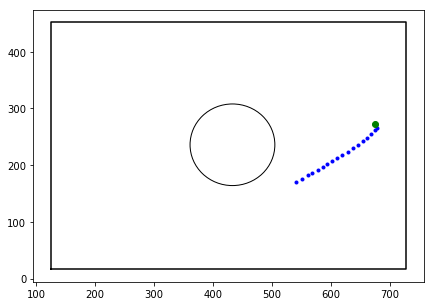

In [6]:
bug.show_sample(train_df, label_df, 5)
# bug.show_preds(train_df, label_df, preds_df, 5)

In [7]:
run1 = {"data_sampler": "random", "n_samples": 15000, "n_trains":[10], "n_labels": [1,5,100], 
        "models":[Ridge(), RandomForestRegressor()], "train_features": ["A_x","A_y","B_x","B_y","C_x","C_y","dist_A_left","dist_A_top","dist_A_right","dist_A_bottom","dist_A_center","dist_B_left","dist_B_top","dist_B_right","dist_B_bottom","dist_B_center"], "label_features": ['C_x', 'C_y'] }

d = bug.multi_run(run1)
# print(d["rmse_results"])


score: 2.9124646648578123, model: Ridge, n_samples: 15000, n_train: 10, n_label: 1
score: 4.558312896570465, model: RandomForestRegressor, n_samples: 15000, n_train: 10, n_label: 1
score: 6.855211746535107, model: Ridge, n_samples: 15000, n_train: 10, n_label: 5
score: 7.821652860218256, model: RandomForestRegressor, n_samples: 15000, n_train: 10, n_label: 5
score: 115.17583617340517, model: Ridge, n_samples: 15000, n_train: 10, n_label: 100
score: 90.43016105842557, model: RandomForestRegressor, n_samples: 15000, n_train: 10, n_label: 100


In [18]:
run1 = {"data_sampler": "random", "n_samples": 15000, "n_trains":[20], "n_labels": [1,5,100], 
        "models":[Ridge(), RandomForestRegressor()], "train_features": ["A_x","A_y","B_x","B_y","C_x","C_y","dist_A_left","dist_A_top","dist_A_right","dist_A_bottom","dist_A_center","dist_B_left","dist_B_top","dist_B_right","dist_B_bottom","dist_B_center"], "label_features": ['C_x', 'C_y'] }
d = bug.multi_run(run1)



score: 4.190920395084451, model: Ridge, n_samples: 15000, n_train: 20, n_label: 1
score: 5.187448270152735, model: RandomForestRegressor, n_samples: 15000, n_train: 20, n_label: 1
score: 8.191079225413915, model: Ridge, n_samples: 15000, n_train: 20, n_label: 5
score: 8.57814398883258, model: RandomForestRegressor, n_samples: 15000, n_train: 20, n_label: 5
score: 120.39415362819287, model: Ridge, n_samples: 15000, n_train: 20, n_label: 100
score: 90.94199610058972, model: RandomForestRegressor, n_samples: 15000, n_train: 20, n_label: 100


score: 119.15966829379437, model: RandomForestRegressor, n_samples: 527, n_train: 20, n_label: 100
rmse: 238.24366661965016, mean error: 164.506875
(2, 20)


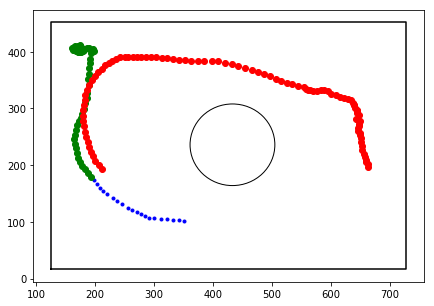

In [11]:
run1 = {"data_sampler": "ordered", "n_samples": 5000, "n_trains":20, "n_labels": 100, 
        "models":RandomForestRegressor(), "train_features": ["A_x","A_y","B_x","B_y","C_x","C_y","dist_A_left","dist_A_top","dist_A_right","dist_A_bottom","dist_A_center","dist_B_left","dist_B_top","dist_B_right","dist_B_bottom","dist_B_center"], "label_features": ['C_x', 'C_y'] }
model, d = bug.single_run(run1)
check_model(run1, model)

rmse: 156.6940018794593, mean error: 113.92825000000002


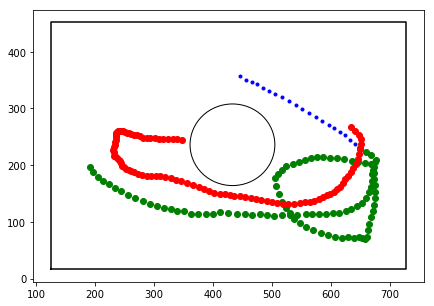

In [167]:
check_model(run1, model)

score: 103.82720724188859, model: RandomForestRegressor, n_samples: 5000, n_train: 20, n_label: 100
rmse: 69.02507515388882, mean error: 53.84224999999999


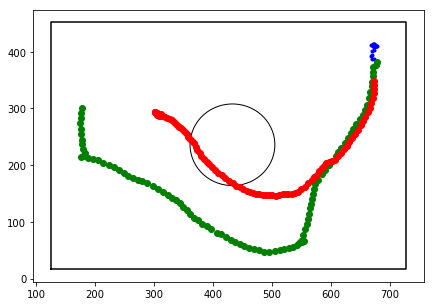

In [169]:
run1 = {"data_sampler": "random", "n_samples": 5000, "n_trains":20, "n_labels": 100, 
        "models":RandomForestRegressor(), "train_features": ["A_x","A_y","B_x","B_y","C_x","C_y","dist_A_left","dist_A_top","dist_A_right","dist_A_bottom","dist_A_center","dist_B_left","dist_B_top","dist_B_right","dist_B_bottom","dist_B_center"], "label_features": ['C_x', 'C_y'] }
model, d = bug.single_run(run1)
check_model(run1, model)

rmse: 50.60591384042975, mean error: 39.847375
(2, 20)


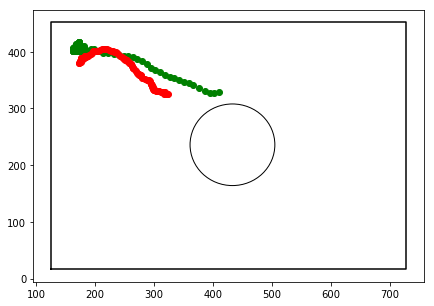

In [10]:
def check_model(prms_dic, model):
    train_one, label_one = bug.split_all_videos_random(1, prms_dic["n_trains"], prms_dic["n_labels"], 
                                                                   prms_dic["train_features"], 
                                                                   prms_dic["label_features"], 
                                                                   debug=False)
    preds = model.predict(train_one)
    print("rmse: {}, mean error: {}".format(bug.rmse(preds, label_one.values), np.mean(np.abs(preds-label_one.values))))
    train_one_pairs = bug.reshape_df_for_show(train_one)
    label_one_pairs = bug.reshape_df_for_show(label_one)
    preds_pairs = bug.reshape_np_for_show(preds)
    print(train_one_pairs.shape)
    bug.show_pred(train_one_pairs, label_one_pairs, preds_pairs)
check_model(run1, model)

In [31]:
preds.shape

NameError: name 'preds' is not defined

In [15]:
run2 = {"data_sampler": "random", "n_samples":1500, "n_trains":[20], "n_labels": [1,5,100], 
        "models":[Ridge()], "train_features": ["C_x","C_y"], "label_features": ['C_x', 'C_y'] }

d = bug.multi_run(run2)

score: 3.76661012138589, model: Ridge, n_samples: 1500, n_train: 20, n_label: 1
score: 8.625003263788269, model: Ridge, n_samples: 1500, n_train: 20, n_label: 5
score: 119.76055387330999, model: Ridge, n_samples: 1500, n_train: 20, n_label: 100


[4.6387098474753365, 4.022514344365051, 3.451220380345995, 3.7756347186115136, 3.9240100376215636, 3.95282507382786, 4.242088323979196, 4.2844233376437515, 3.968773673122864, 4.217991788874924, 4.090966319556591, 3.8885171790674393, 4.184955333801465, 4.188622673432256, 4.0848553788043755, 4.064984450527128, 4.248860080519104, 3.8595873858285366, 4.091610671926055, 4.237643189408351]
[4.974765114503922, 4.069822410861648, 3.826313084673462, 3.8504239454877407, 4.139042480248125, 4.035820562226621, 4.245521441736008, 4.1244370154570325, 3.997499068294803]


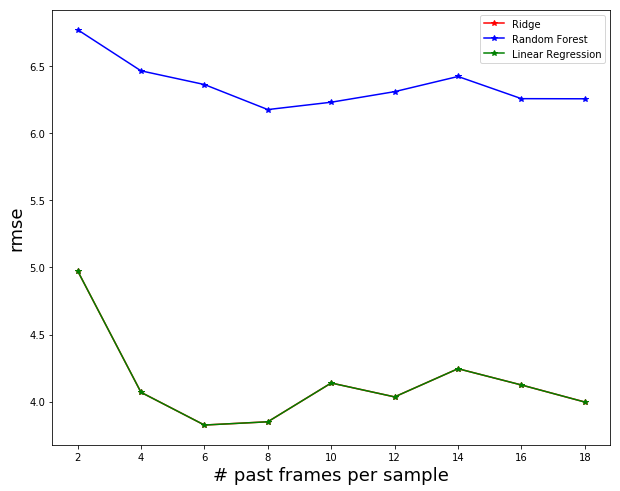

In [90]:
print(results_all)

fig,ax = plt.subplots(figsize = (10,8))
ax.plot(n_trains, results_ridge, 'r*-', label='Ridge')
ax.plot(n_trains, results_rf, 'b*-', label='Random Forest')
ax.plot(n_trains, results_linear, 'g*-', label='Linear Regression')
ax.legend()
plt.xlabel("# past frames per sample", fontsize=18)
plt.ylabel("rmse", fontsize=18)
print(results_ridge)

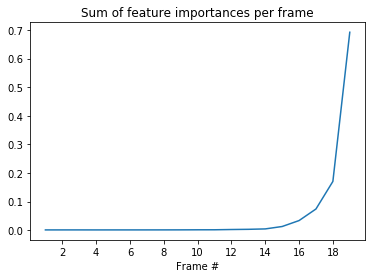

In [169]:
from matplotlib.ticker import MaxNLocator
plt.plot(np.arange(1,20), rf.feature_importances_.reshape(19,16).sum(axis=1))
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.xlabel("Frame #")
plt.title("Sum of feature importances per frame")

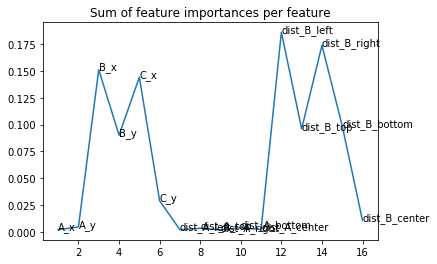

In [181]:
from matplotlib.ticker import MaxNLocator
xs = np.arange(1,17)
ys = rf.feature_importances_.reshape(19,16).sum(axis=0)
plt.plot(xs, ys)
ax = plt.gca()
for i, txt in enumerate(df.iloc[:,8:].columns):
    ax.annotate(txt, (xs[i],ys[i]))
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
# plt.xlabel("Feature #")
# plt.gca().set_xticklabels(df.iloc[:,8:].columns[::2])
plt.title("Sum of feature importances per feature")

In [173]:
df.iloc[:,8:].columns[15]

'dist_B_center'

# results using C_x, C_y only as features
ordered samples, 1 movie  
n_train_frames=19  
n_test_frames=1  
**RF (n_estimators=500)**  
Model trained (2.5484297275543213 seconds). Train score: 7.1290825838968095, test score: 11.514212490530277  
**Ridge**  
Model trained (0.04400348663330078 seconds). Train score: 2.8489899146736204, test score: 19.901146078544908  
**Linear Regression**  
Model trained (0.05202293395996094 seconds). Train score: 2.8489808147245377, test score: 19.901146078544908
# results using all features
ordered samples, 1 movie  
n_train_frames=19  
n_test_frames=1  
RF  
Model trained (13.325051069259644 seconds). Train score: 7.790062174672226, test score: 19.844266379758  
Ridge  
Model trained (0.007999658584594727 seconds). Train score: 3.2874721634444493, test score: 6.262216912537541  
Linear Regression  
Model trained (0.012000322341918945 seconds). Train score: 3.323811233046511, test score: 6.35928398745195